# Number of samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

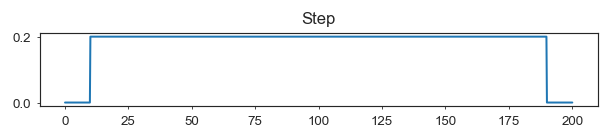

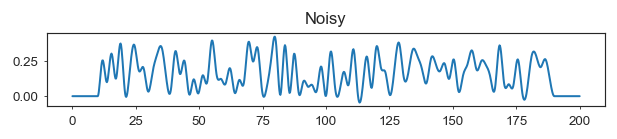

In [6]:
from neuroprobnum.utils import stim_utils

t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stims = [
    stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step'),
    stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46),

]
for stim in stims: stim.plot(t0=t0, tmax=tmax)

# Data

## Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
from copy import deepcopy

gens = {}

for stim in stims:
    
    neuron = deepcopy(neuron)
    neuron.get_Istim_at_t = stim.get_I_at_t
    
    gens[stim] = DataGeneratorHH(
        return_vars=['ys', 'events'],
        y0=neuron.compute_yinf(-65), t0=t0, tmax=tmax,
        t_eval_adaptive=math_utils.t_arange(t0, tmax, 1),
        model=neuron, n_samples=300, n_parallel=20, dt_min_eval_fixed=0.1,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data',
    )
    gens[stim].update_subfoldername(stim=stim.name)
    gens[stim].load_acc_sols_from_file()    

## Generate data

In [8]:
# pert_method, adaptive, methods, step_params, pert_params
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.1], [1]),
    ('conrad', 1, ['RKBS'], [1e-2], [1]),
]

----------------------------------------------------------
IStimStep(0.2,t=[10,190]) : stim_Step_tmax_200
----------------------------------------------------------
                                 EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because overwrite==True.


  0%|          | 0/300 samples [00:00<?]

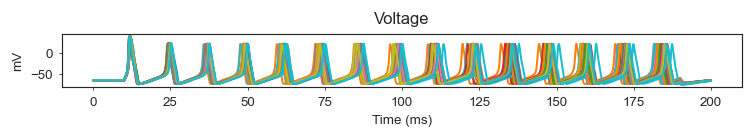

                                  RKBS_a(0.01)_conrad(1).pkl --> Generate data because overwrite==True.


  0%|          | 0/300 samples [00:00<?]

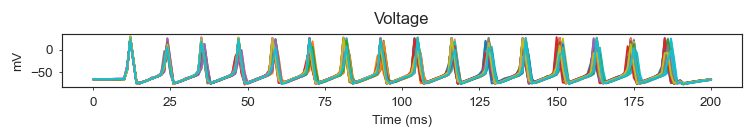

----------------------------------------------------------
IStimNoisy(0.2,t=[10,190],I=[0.00,0.00]) : stim_Noisy_tmax_200
----------------------------------------------------------
                                 EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because overwrite==True.


  0%|          | 0/300 samples [00:00<?]

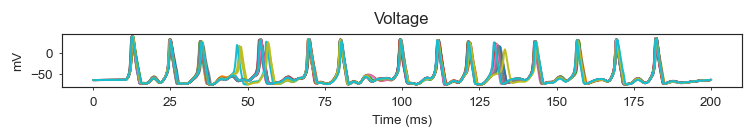

                                  RKBS_a(0.01)_conrad(1).pkl --> Generate data because overwrite==True.


  0%|          | 0/300 samples [00:00<?]

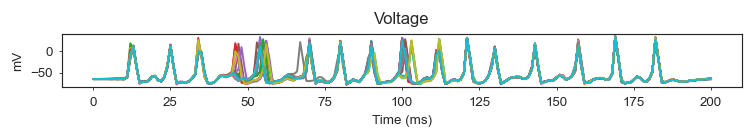

In [9]:
for stim, gen in gens.items():
    
    print('----------------------------------------------------------')
    print(stim, ':', gen.subfoldername)
    print('----------------------------------------------------------')   
    
    for pert_method, adaptive, methods, step_params, pert_params in solver_params:
        for method, step_param, pert_param in itproduct(methods, step_params, pert_params):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, pert_param=pert_param,
                overwrite=True, plot=True,
            )

# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = pd.DataFrame()
for stim, gen in gens.items():
    stim_df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, MAEs=False)
    stim_df['stimfun'] = stim
    stim_df['stim'] = stim.name
    df = df.append(stim_df, ignore_index=True)

In [11]:
df.head()

,acc_events,acc_ts,acc_vs,adaptive,det_events,det_nODEcalls,det_run_time,det_ts,det_vs,events,...,pert_param,run_times,seed,step_param,t0,tmax,ts,vs,stimfun,stim
0,"[[11.270881645965623, 23.333899356067306, 34.9...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,"[[11.515458239970659, 24.26033137599879, 36.51...",2000.0,0.047131,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...","[[[11.670185515918213, 24.80251910835875, 36.8...",...,1.0,"[0.07447028160095215, 0.0809025764465332, 0.08...","[12475674, 1080776788, 1858585705, 1629164900,...",0.10,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimStep(0.2,t=[10,190])",Step
1,"[[11.270881645965643, 23.333899356067125, 34.9...","[0.0, 1.0, 2.0, 2.9999999999999787, 3.99999999...","[-65.0, -64.9997390179966, -64.99956670409958,...",1,"[[11.273499340450389, 23.32225734822555, 34.93...",2698.0,0.083499,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-65.0, -64.99973714654396, -64.99958651618194...","[[[11.286619246108451, 23.213623306467586, 34....",...,1.0,"[0.11579442024230957, 0.11498141288757324, 0.1...","[12475674, 1080776788, 1858585705, 1629164900,...",0.01,0.0,200.0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[-65.0, -64.99974478827235, -64.9995810236783...","IStimStep(0.2,t=[10,190])",Step
2,"[[12.028135882000429, 24.247888925122762, 33.9...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,"[[12.30965602183789, 24.529619570250237, 34.54...",2000.0,0.070274,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996870091516, -64.99993945138549...","[[[12.376576620196262, 24.70678763900752, 34.5...",...,1.0,"[0.10763978958129883, 0.10973024368286133, 0.1...","[12475674, 1080776788, 1858585705, 1629164900,...",0.10,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimNoisy(0.2,t=[10,190],I=[0.00,0.00])",Noisy
3,"[[12.028135882000427, 24.247888925117078, 33.9...","[0.0, 1.0, 2.0, 2.9999999999999787, 3.99999999...","[-65.0, -64.9997390179966, -64.99956670409958,...",1,"[[12.02633986192225, 24.25932123488692, 33.955...",2803.0,0.114634,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-65.0, -64.99973714654396, -64.99958651618194...","[[[12.049306794508947, 24.217475295594383, 33....",...,1.0,"[0.16601920127868652, 0.17414450645446777, 0.1...","[12475674, 1080776788, 1858585705, 1629164900,...",0.01,0.0,200.0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[[-65.0, -64.99974478827235, -64.9995810236783...","IStimNoisy(0.2,t=[10,190],I=[0.00,0.00])",Noisy


In [12]:
from neuroprobnum.utils import metric_utils

np.random.seed(326)

# Parameters
n_samples_list = [2, 3, 5, 10, 20]
n_boot = 10000

In [13]:
def bootstrap_MAE_SM(samples, n_drawn, n_boot):
    SM_boot = np.empty(n_boot)
    
    for i in range(n_boot):
        idxs = np.random.choice(np.arange(0, samples.shape[0]), n_drawn, replace=False)
        SM_boot[i] = np.mean(metric_utils.compute_sample_sample_distances(samples=samples[idxs], metric='MAE'))
    
    return SM_boot


df['avg_MAE_SM'] = None
for n in n_samples_list:
    df[f'avg_MAE_SM_n{n}'] = None
    df[f'avg_MAE_ratio_SM_n{n}'] = None
    
for rowi, row in df.iterrows():  
    df.at[rowi, 'avg_MAE_SM'] = np.mean(metric_utils.compute_sample_sample_distances(samples=row.vs, metric='MAE'))
    
    for n in n_samples_list:
        MAE_SM_n = bootstrap_MAE_SM(samples=row.vs, n_drawn=n, n_boot=n_boot)
            
        df.at[rowi, f'avg_MAE_SM_n{n}'] = MAE_SM_n
        df.at[rowi, f'avg_MAE_ratio_SM_n{n}'] = df.at[rowi, f'avg_MAE_SM_n{n}'] / df.at[rowi, 'avg_MAE_SM']

In [14]:
import pyspike as spk

df['spikedist_SS'] = None

for rowi, row in df.iterrows():
    n_samples_tot = int(row.n_samples)

    spike_times_list = np.asarray([np.array(e_list[0]) for e_list in row.events], dtype=object)
    spike_trains = np.asarray([spk.SpikeTrain(spike_times, edges=[row.t0, row.tmax]) for spike_times in spike_times_list], dtype=object)

    spikedist_SS = np.full((n_samples_tot, n_samples_tot), np.nan)
    
    for i, sti in enumerate(spike_trains):
        for j, stj in enumerate(spike_trains[i+1:], start=i+1):
            dist = metric_utils.compute_spike_distance(sti, stj, t0=row.t0, tmax=row.tmax)
            spikedist_SS[i, j] = dist
            spikedist_SS[j, i] = dist
            
    df.at[rowi, 'spikedist_SS'] = spikedist_SS

In [15]:
def bootstrap_dist_SS(dist_SS, n_drawn, n_boot):
    SM_boot = np.full(n_boot, np.nan)
    
    for i in range(n_boot):
        idxs = np.random.choice(np.arange(0, dist_SS.shape[0]), n_drawn, replace=False)
        SM_boot[i] = np.mean((dist_SS[idxs][:, idxs])[np.triu_indices(idxs.size, k=1)])
    
    return SM_boot


df['avg_spikedist_SM'] = None
for n in n_samples_list:
    df[f'avg_spikedist_SM_n{n}'] = None
    df[f'avg_spikedist_ratio_SM_n{n}'] = None

for rowi, row in df.iterrows():
    df.at[rowi, 'avg_spikedist_SM'] = np.mean(row.spikedist_SS[np.triu_indices(row.n_samples, k=1)])
    
    for n in n_samples_list:
        spikedist_SM_n = bootstrap_dist_SS(row.spikedist_SS, n, n_boot)
        
        df.at[rowi, f'avg_spikedist_SM_n{n}'] = spikedist_SM_n
        df.at[rowi, f'avg_spikedist_ratio_SM_n{n}'] = df.at[rowi, f'avg_spikedist_SM_n{n}'] / df.at[rowi, 'avg_spikedist_SM']

# Figure

In [16]:
stim2color = {}
stim2color[stims[0].name] = 'dimgray'
stim2color[stims[1].name] = 'black'

## Plot functions

How many samples are needed to get a good estimate of the SS distance and therefore a estimate for the SR distance.

In [17]:
def plot_R_distribution(ax, df, transform=None, lb=None, ub=None, metric='avg_MAE_ratio_SM'):
    """Plot R distributions as violins as a function of the stimulus and sample number"""
    assert df.method.nunique() == 1
    assert df.adaptive.nunique() == 1
    assert df.pert_method.nunique() == 1
    assert df.step_param.nunique() == 1
    
    if transform is None: transform = lambda x: x
    
    # Plot ratio distribution
    plot_df = pd.DataFrame()
    for _, row in df.iterrows():
        plot_df = plot_df.append(pd.DataFrame({
            'n': np.repeat(n_samples_list, n_boot),
            'stim': np.repeat(row.stim, n_boot*len(n_samples_list)),
            'R': transform(np.concatenate([row[f'{metric}_n{n}'] for n in n_samples_list])),
        }))

    sns.violinplot(
        ax=ax, data=plot_df, x='n', y='R', hue='stim',# scale="width",
        hue_order=[stim.name for stim in stims],
        palette=[stim2color[stim.name] for stim in stims],
        split=False, cut=0, linewidth=0.1, width=0.8, inner=None,
    )
    ax.legend().set_visible(False)
    
    if lb is not None and ub is not None:
        ax.axhline(transform(lb), color='gray', ls=':', alpha=1.0, zorder=-1000)
        ax.axhline(transform(1), color='gray', ls='-', alpha=1.0, zorder=-1000)
        ax.axhline(transform(ub), color='gray', ls=':', alpha=1.0, zorder=-1000)
    
    ax.set_xlabel('Number of samples')
    ax.set_xticks(np.arange(len(n_samples_list)))
    ax.set_xticklabels(n_samples_list)

In [18]:
from matplotlib.ticker import FuncFormatter

def plot_R_summary(ax, rows, lb, ub, marker, ls, metric='avg_MAE_ratio_SM'):
    for _, row in rows.iterrows():
        percentages = []
        for n in n_samples_list:
            percentages.append(
                np.mean((row[f'{metric}_n{n}'] >= lb) & (row[f'{metric}_n{n}'] <= ub))
            )
    
        ax.plot(percentages, color=stim2color[row.stim], marker=marker, ls=ls, label=row.stim, clip_on=False)
        print(row.stim, percentages)
        
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_xticks(np.arange(len(n_samples_list)))
    ax.set_xticklabels(n_samples_list)
    ax.set_xlabel('Number of samples')

# Plot

In [19]:
def plot_RSM(axs, df_methods, x='R_SM', metric='avg_MAE_ratio_SM', lb=0.5, ub=2.0):
    assert axs.shape == (2, 2)
    
    for ax_col, ((method, pert_method, adaptive), df_method) in zip(axs.T, df_methods):
        # Plot R distributions
        plot_R_distribution(ax=ax_col[0], df=df_method, transform=logfun, lb=lb, ub=ub, metric=metric)
        logbase = int(f"{logfun}".split('log')[1].split('\'')[0])
        ax_col[0].set_ylabel(pltu.text2mathtext(f'log_{logbase} ({x} )'))
        # Plot R in bounds
        plot_R_summary(ax_col[1], rows=df_method, lb=lb, ub=ub, marker='o', ls='-', metric=metric)
        ax_col[1].set_ylabel(pltu.text2mathtext(f'{x} \in') + '\n' + f'[{lb:.2f}, {ub:.1f}]')   

    #### Decorate ###
    for ax_col, ((method, pert_method, adaptive), _) in zip(axs.T, df_methods):
        ax_col[0].set_title(pltu.method2label(method=method, adaptive=adaptive, pert_method=pert_method)) 

    for ax in axs[:, 1:].flat:
        ax.set(ylabel=None)

    for ax in axs[:-1, :].flat:
        ax.set(xlabel=None)

    pltu.make_share_ylims(axs[0])
    pltu.make_share_ylims(axs[1])    

### MAE

In [20]:
logfun = np.log2

In [21]:
df_methods = df.groupby(['method', 'pert_method', 'adaptive'], sort=False)

In [22]:
ylim = (
    logfun(np.minimum(np.stack(df.avg_MAE_ratio_SM_n2).min(), np.stack(df.avg_spikedist_ratio_SM_n2)).min())+0.05,
    logfun(np.maximum(np.stack(df.avg_MAE_ratio_SM_n2).min(), np.stack(df.avg_spikedist_ratio_SM_n2)).max())+0.05,
)

ylim

(-3.534242423778104, 3.044325285623398)

In [23]:
def fix_axis(axs):
    for ax in axs[0, :]:
        ax.set_yticks([-3, -2, -1, 0, 1, 2])
        ax.set_yticklabels(["", -2, "", 0, "", 2])
        ax.set_ylim(ylim)

    for ax in axs[1, :]:
        ax.set_yticks([0.5, 0.75, 1.0])
        ax.set_ylim(0.35, 1)

Step [0.8527, 0.9902, 0.9995, 1.0, 1.0]
Noisy [0.842, 0.8993, 0.9619, 0.9988, 1.0]
Step [0.8014, 0.9613, 0.9978, 1.0, 1.0]
Noisy [0.7337, 0.8133, 0.937, 0.9953, 0.9999]


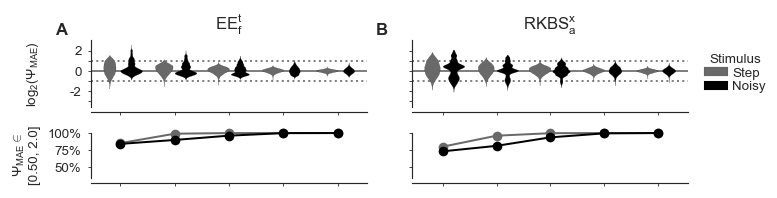

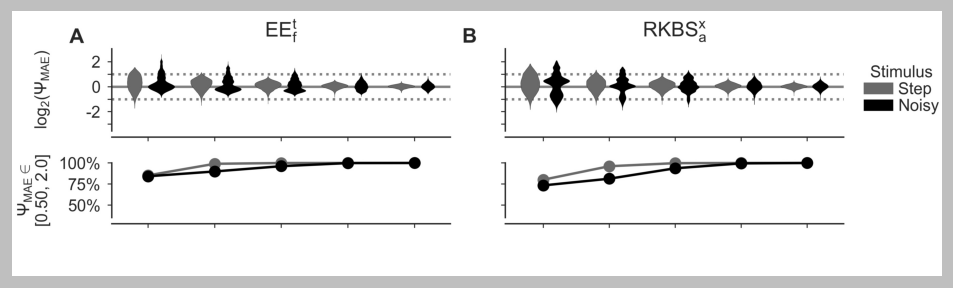

In [24]:
### Metric parameters ###
fig, axs = pltu.subplots(len(df_methods), 2, yoffsize=0.4, ysizerow=0.7, squeeze=False, xsize='fullwidth', gridspec_kw=dict(height_ratios=[1.5, 1]), sharex='col', sharey='row')
sns.despine()
pltu.set_labs(axs[0, :], panel_nums='auto', panel_num_space=5, panel_num_va='top', panel_num_y=1.1)

plot_RSM(axs, df_methods, x='\Psi_MAE', metric='avg_MAE_ratio_SM', lb=0.5, ub=2.0)

axs[0, -1].legend(loc='center left', title='Stimulus', bbox_to_anchor=(1.05, 0.5))

fix_axis(axs)

pltu.move_xaxis_outward(axs)

plt.tight_layout(h_pad=1, pad=0.2, w_pad=2)
fig.align_labels()

for ax in axs.flat:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

pltu.savefig('fig7a_b')
pltu.show_saved_figure(fig)
plt.show()

### Spike distance

Step [0.7431, 0.9033, 0.982, 1.0, 1.0]
Noisy [0.3932, 0.4606, 0.6069, 0.8406, 0.9725]
Step [0.7502, 0.9093, 0.9841, 0.9999, 1.0]
Noisy [0.502, 0.6612, 0.8509, 0.9567, 0.9935]


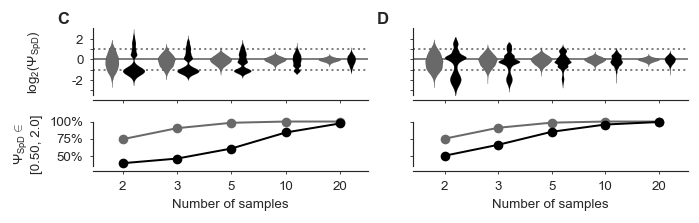

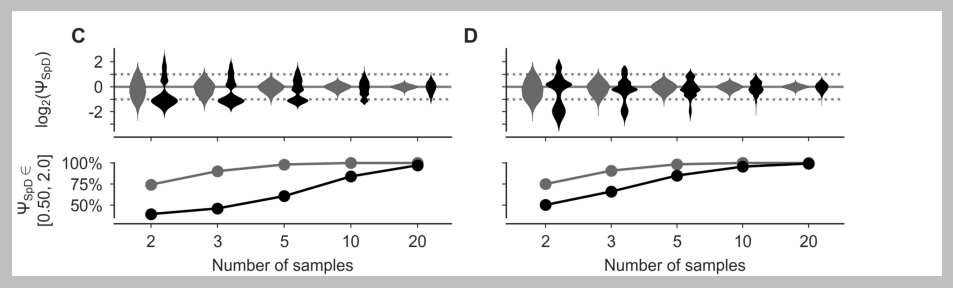

In [25]:
### Metric parameters ###
fig, axs = pltu.subplots(len(df_methods), 2, yoffsize=0.4, ysizerow=0.7, squeeze=False, xsize='fullwidth', gridspec_kw=dict(height_ratios=[1.5, 1]), sharex='col', sharey='row')
sns.despine()
pltu.set_labs(axs[0, :], panel_nums=['C', 'D'], panel_num_space=5, panel_num_va='top', panel_num_y=1.1)

plot_RSM(axs, df_methods, x='\Psi_SpD', metric='avg_spikedist_ratio_SM', lb=0.5, ub=2.0)

axs[0, -1].legend(loc='center left', title='Stimulus', bbox_to_anchor=(1.05, 0.5))

pltu.move_xaxis_outward(axs)

fix_axis(axs)

plt.tight_layout(h_pad=1, pad=0.2, w_pad=2)
fig.align_labels()

for ax in axs.flat:
    ax.set_title(None)
    try:
        ax.get_legend().set_visible(False)
    except:
        pass

pltu.savefig('fig7c_d')
pltu.show_saved_figure(fig)
plt.show()

# Text

In [26]:
df[df.stim == 'Noisy'].avg_MAE_ratio_SM_n2.apply(lambda x: np.mean(np.abs(np.log2(x)) < 1))

2    0.8420
3    0.7337
Name: avg_MAE_ratio_SM_n2, dtype: float64

In [27]:
df[df.stim == 'Step'].avg_MAE_ratio_SM_n2.apply(lambda x: np.mean(np.abs(np.log2(x)) < 1))

0    0.8527
1    0.8014
Name: avg_MAE_ratio_SM_n2, dtype: float64

In [28]:
df[df.stim == 'Step'].avg_spikedist_ratio_SM_n2.apply(lambda x: np.mean(np.abs(np.log2(x)) < 1))

0    0.7431
1    0.7502
Name: avg_spikedist_ratio_SM_n2, dtype: float64

In [29]:
df[df.stim == 'Noisy'].avg_spikedist_ratio_SM_n10.apply(lambda x: np.mean(np.abs(np.log2(x)) < 1))

2    0.8406
3    0.9567
Name: avg_spikedist_ratio_SM_n10, dtype: float64